# Generate 

 - for two use cases

In [1]:
#def degrees_to_cardinal(d):
#    '''
#    note: this is highly approximate...
#    '''
#    dirs = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
#            "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
#    ix = int((d + 11.25)/22.5)
#    return dirs[ix % 16]

textures  = ["Asphalt", "Gravel", "Cobble"]

import uuid
import pandas as pd
import seaborn as sns


In [344]:
class PathSegment:
    '''Class for keeping track of an item in inventory.'''
    def __init__(self, segid, length, texture, direction, width, inclination):
        self.segid = segid
        self.length = length
        self.texture = texture
        self.direction = direction
        self.width = width
        self.inclination = inclination
        
    def __repr__(self):
        return f"{self.segid}: {self.length} - {self.direction} - {self.texture}"
    
    def __todict__(self):
        return {
            'segid': self.segid,
            'texture': self.texture,
            'direction': self.direction,
            'width': self.width,
            'inclination': self.inclination
        }
    
    

In [345]:
import random
random.randint(50,300)


97

In [536]:
segs = []
n_sim = 5000
for i in range(1,n_sim):
    p = PathSegment(
                segid = str(uuid.uuid1())[0:8],
                length=random.random()*10,
                texture=textures[random.randint(0,2)],
                #direction = degrees_to_cardinal(random.randint(0,180)),
                direction = random.randint(0, 359),
                width = np.random.normal(50,300),
                inclination = abs(np.random.normal(0,7)) * [-1,1][random.randint(0,1)]
    )
    segs.append(p)
    

In [537]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scaler.fit_transform(sim.direction)



In [584]:
median_speed = 12.3

def adapt_median_speed(condition, segment):
    m = median_speed
    if segment.texture == "Gravel":
        m = 9.8
    elif segment.texture == "Cobble":
        m = 11.4
    
    # per 10 mm of rainfall penalize 0.1 kmh
    delta = -condition.rain/10
    
    # wind
    dirs = condition.winddir, segment.direction
    degree_diff = (max(dirs) - min(dirs)) 
    degree_diff = degree_diff - 180 if degree_diff > 180 else degree_diff # 0 = headwind, 180 = tailwind
    # wind penalization: 10kmh wind -> -+ 0.1kmh
    tail_or_head = 1 if degree_diff-90 > 0 else -1
    degree_effect = abs(90-degree_diff)/90 * tail_or_head
    wind_effect = (condition.wind/10 * degree_effect)
    delta = delta + wind_effect
    
    
    # width factor inverts if busy: -1 = totally busy, 1 = free highway
    width_factor = (50/300) if condition.busy > 0 else  1 - (50/300)
    busy_width_delta = m * 0.2 * (condition.busy) * width_factor
    
    #if delta > 0:
    #    delta = delta * (1 - condition.busy) #* segment.width / 300 
    #else: 
    #    delta = delta + abs(delta) * (1 - condition.busy) #* segment.width / 300 
    
    m_new = m + delta + busy_width_delta
    
    inclination_delta = m_new * 0.3 * segment.inclination / 12
    
    segment.wind_effect = wind_effect 
    
    return m_new + inclination_delta


In [585]:
class Condition:
    
    def __init__(self, temp, rain, wind, winddir, busy):
        self.temp = temp
        self.rain = rain 
        self.wind = wind
        self.winddir = winddir
        self.busy = busy
        
    temp: float # -20 to 20
    rain: float # 0 - 22mm/h
    wind: int # kmh
    winddir: int # degree
    busy: float # -1 to 1


In [586]:
summer_afternoon =  Condition(temp=24, rain=0, wind=4, winddir=180, busy=0.95)
summer_night =  Condition(temp=21, rain=0, wind=4, winddir=180, busy=-0.8)

rainy_november = Condition(temp=3, rain=22, wind=30, winddir=180, busy=0.1)
rainy_november_nowind = Condition(temp=3, rain=22, wind=5, winddir=180, busy=0.1)

In [587]:
[adapt_median_speed(friday_afternoon, s) for s in segs]

def create_conditions_df(conditions):
    return pd.DataFrame(
        [pd.Series([adapt_median_speed(c, s) for s in segs], name=n) for n,c in conditions.items()]
    ).T.join(pd.DataFrame([p.__todict__() for p in segs]))


snapshots = {
                    "rainy_windy_november": rainy_november, 
                    "rainy_november": rainy_november_nowind,
                    "summer_afternoon": summer_afternoon,
                    "summer_night": summer_night
}

sim = create_conditions_df(snapshots)
sim.head()

,rainy_windy_november,rainy_november,summer_afternoon,summer_night,direction,inclination,segid,texture,width
0,10.072495,9.206472,11.441950,9.634139,305,-4.369324,4e6e0ebe,Asphalt,457.378846
1,8.176687,9.713885,12.293798,10.288249,146,-0.472044,4e6e126a,Asphalt,-302.364023
2,8.337395,7.580374,9.961637,8.387791,62,-1.067499,4e6e145e,Gravel,166.145882
3,10.169530,8.295764,10.792081,9.113994,25,1.511109,4e6e1602,Gravel,110.088871
4,8.276112,6.608904,8.579315,7.249843,343,-7.112609,4e6e177e,Gravel,-95.071207


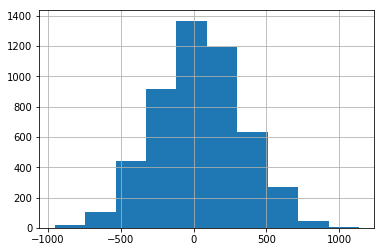

In [555]:
sim.width.hist()

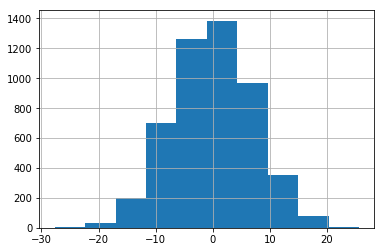

In [556]:
sim.inclination.hist()

In [557]:
simmelt.cond.value_counts()

summer_afternoon        4999
summer_night            4999
rainy_november          4999
rainy_windy_november    4999
Name: cond, dtype: int64

In [566]:
simmelt = pd.melt(sim, value_vars = snapshots.keys(), 
        id_vars = ['direction', 'segid', 'texture', 'width', 'inclination'],
        value_name='avg_speed', var_name = 'cond')
simmelt.head()

,direction,segid,texture,width,inclination,cond,avg_speed
0,305,4e6e0ebe,Asphalt,457.378846,-4.369324,rainy_windy_november,10.072495
1,146,4e6e126a,Asphalt,-302.364023,-0.472044,rainy_windy_november,8.176687
2,62,4e6e145e,Gravel,166.145882,-1.067499,rainy_windy_november,8.337395
3,25,4e6e1602,Gravel,110.088871,1.511109,rainy_windy_november,10.169530
4,343,4e6e177e,Gravel,-95.071207,-7.112609,rainy_windy_november,8.276112


In [567]:
sim.to_csv("simulated-speeds.tsv",sep='\t')

No handles with labels found to put in legend.


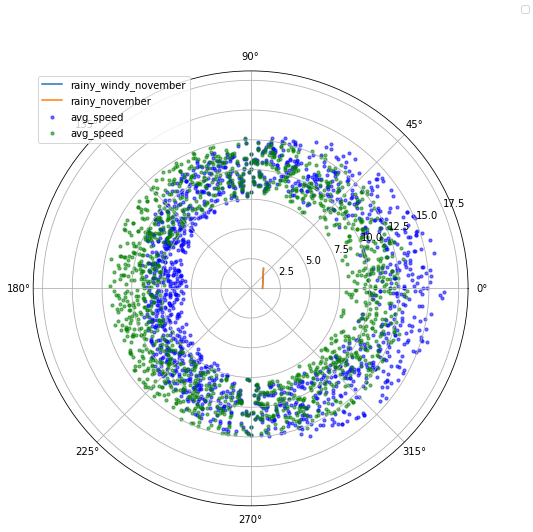

In [579]:
import numpy as np
import matplotlib.pyplot as plt

def comparison_radial_plot(cond1, cond2, filterq=""):

    # Fixing random state for reproducibility
    np.random.seed(19680801)

    # Compute areas and colors
    asphalt_nov_avg = simmelt.query(f" cond == '{cond1}' {filterq} ").avg_speed
    asphalt_novnowind_avg = simmelt.query(f"cond == '{cond2}' {filterq}").avg_speed

    #theta = 2 * np.pi * np.random.rand(n_sim)
    asphalt_nov_dir =  simmelt.query(f" cond == '{cond1}' {filterq}").direction
    asphalt_novnowind_dir =  simmelt.query(f"cond == '{cond2}' {filterq}").direction


    fig = plt.figure(figsize=(8,8))
    fig.legend()
    ax = fig.add_subplot(111, projection='polar')
    c = ax.scatter(2 * np.pi * asphalt_nov_dir / 360, asphalt_nov_avg, s=10, c="blue", alpha=0.55)
    c = ax.scatter(2 * np.pi * asphalt_novnowind_dir / 360, asphalt_novnowind_avg, c="green", s=10, alpha=0.55)
    
    line, = ax.plot([1,2], label=cond1)
    line, = ax.plot([1,2], label=cond2)
    ax.legend()
    return fig

fig = comparison_radial_plot('rainy_windy_november', 'rainy_november', 
                       " and texture=='Asphalt' and -10 < inclination < 10")
fig.savefig("./windy-vs-nonwindy.png")


No handles with labels found to put in legend.


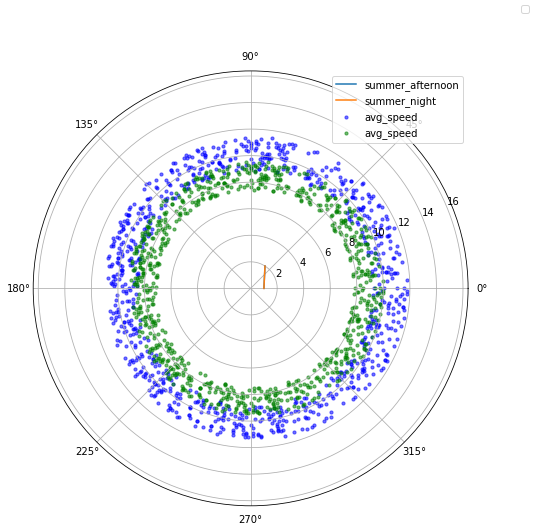

In [573]:
comparison_radial_plot('summer_afternoon', 'summer_night',  " and texture=='Gravel' and -5 < inclination < 5")

/Users/michael/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


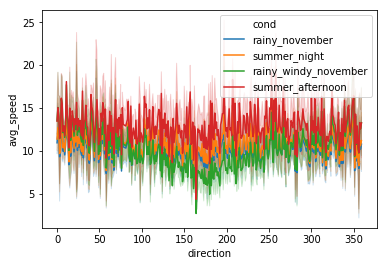

In [549]:
sns.lineplot(data=simmelt.query("texture=='Asphalt'").sort_values('direction'), 
             x="direction", y="avg_speed", hue="cond")

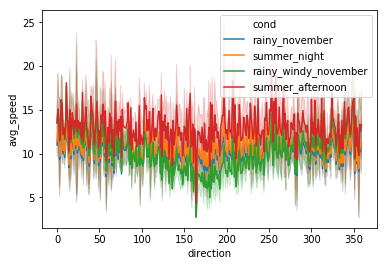

In [550]:
sns.lineplot(data=simmelt.query("texture=='Asphalt'").sort_values('direction'), 
             x="direction", y="avg_speed", hue="cond")

In [108]:
segs_df = pd.DataFrame([s.__todict__() for s in segs]).reset_index().set_index("segid")
segs_df.head()
#adapt_median_speed(rainy_november,segs[segs_df.ix[13158].index])


,index,direction,self.width,texture
segid,,,,
b32cdb7a,0,93,149,Asphalt
b32cde54,1,60,297,Gravel
b32cdf4e,2,140,159,Gravel
b32cdfee,3,356,137,Cobble
b32ce070,4,163,196,Asphalt


In [109]:
sim.query('texture=="Asphalt" and cond == "cold_november" and 265 < direction < 275 ')

,index,avg,cond,id,texture,direction
10096,98,12.077778,cold_november,b32d1f72,Asphalt,266
13606,3608,12.077778,cold_november,b334fc1a,Asphalt,266
14822,4824,12.077778,cold_november,b33703f2,Asphalt,266
17411,7413,12.077778,cold_november,b33adebe,Asphalt,266
17954,7956,12.077778,cold_november,b33ba740,Asphalt,266
19780,9782,12.077778,cold_november,b34633ae,Asphalt,266
11134,1136,12.100000,cold_november,b32f3cd0,Asphalt,267
12482,2484,12.100000,cold_november,b332cb48,Asphalt,267
13159,3161,12.100000,cold_november,b3345062,Asphalt,267
14338,4340,12.100000,cold_november,b33642b4,Asphalt,267


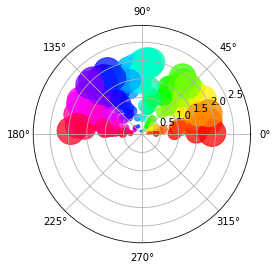

In [71]:
np.random.seed(19680801)

# Compute areas and colors
N = 150
r = 2 * np.random.rand(N)
theta = 2 * np.pi * np.random.rand(N)
area = 200 * r**2
colors = theta

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)

In [55]:
sim.query('texture=="Asphalt" and cond == "cold_november" and direction<10')\
        .sort_values("direction")[["avg","direction"]].drop_duplicates()

,avg,direction
10087,10.033333,0
18093,10.011111,1
15799,9.988889,2
18170,9.966667,3
15229,9.944444,4
10096,9.922222,5
19400,9.900000,6
17918,9.877778,7
19133,9.855556,8
19147,9.833333,9


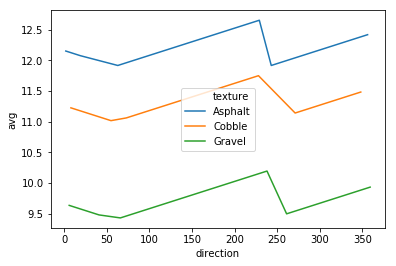

In [340]:
sns.lineplot(data=sim.query("cond=='summer_friday'"),x="direction", y="avg", hue="texture")

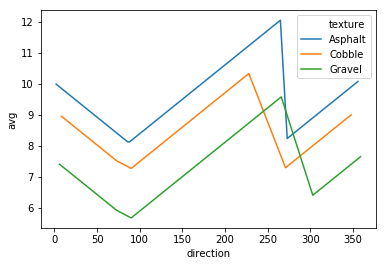

In [328]:
sns.lineplot(data=sim.query("cond=='cold_november'"), x="direction", y="avg", hue="texture")

In [326]:
print(adapt_median_speed(friday_afternoon, segs[0]))
print(adapt_median_speed(rainy_november, segs[0]))

11.926666666666668
11.611111111111112


NameError: name 'm' is not defined